# The influence of weather on bike-sharing
## Sources of datasets:

[London weather data](https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023)

[Bike-Share Usage in London and Taipei Network](https://www.kaggle.com/datasets/ajohrn/bikeshare-usage-in-london-and-taipei-network/data)

### Things to do to run:
* Download these three datasets: London.csv, London_stations.csv (source 2) & london0_23_weather_data.csv (source 1)
* Place the files together with this code in a shared folder

To run the code (in VSC):
* Make sure you have Python installed (I'm using Python 3.11.9)
* To the upper right here, select this Python as kernel
* It migh be that you still need to select an environment to run the code, use .venv
* In the cell below: uncomment the pip-commands (only run this once, then comment them again)
* It should work now :)

## Installing and defining names and files

In [1]:
#pip install pandas

In [2]:
#pip install seaborn

In [3]:
#pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#We only look at the London-data (there is also data from Taipei network)
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape

C:\Users\arthu\AppData\Local\Temp\ipykernel_36344\2391621177.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)


(38215560, 9)

In [6]:
#import the names of the stations (a bit easier to identify stations later)
df_london_geo = pd.read_csv('london_stations.csv')


In [7]:
#import weather data of London (this goes from 2000-2023, so we can discard a lot later)
df_london_weather = pd.read_csv('london0_23_weather_data.csv')

#Deleting NaN's
df_london_weather = df_london_weather.drop('tsun', axis=1)
df_london_weather = df_london_weather.drop('wpgt', axis=1)
df_london_weather['snow'] = df_london_weather['snow'].fillna(0)
df_london_weather['prcp'] = df_london_weather['prcp'].fillna(0)
    # Interpolate the other missing values linearly
df_london_weather = df_london_weather.interpolate(method='linear')
df_london_weather.loc[0, 'wdir'] = 255

#Since there is no explicit date column, I create one for our ease (starting from 01-01-2000):
df_london_weather['date'] = pd.date_range(start='2000-01-01', periods=len(df_london_weather), freq='D') 
# Extract useful time-related features
df_london_weather['day'] = df_london_weather['date'].dt.day
df_london_weather['month'] = df_london_weather['date'].dt.month
df_london_weather['week'] = df_london_weather['date'].dt.isocalendar().week
df_london_weather['dayofweek'] = df_london_weather['date'].dt.dayofweek
df_london_weather['year'] = df_london_weather['date'].dt.year
df_london_weather['satsun'] = df_london_weather['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})

# Display the first few rows
df_london_weather.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,date,day,month,week,dayofweek,year,satsun
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5,2000-01-01,1,1,52,5,2000,True
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2,2000-01-02,2,1,52,6,2000,True
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5,2000-01-03,3,1,1,0,2000,False
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8,2000-01-04,4,1,1,1,2000,False
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6,2000-01-05,5,1,1,2,2000,False
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4,2000-01-06,6,1,1,3,2000,False
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2,2000-01-07,7,1,1,4,2000,False
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4,2000-01-08,8,1,1,5,2000,True


In [8]:
#The data includes rare rental events that are started but not ended. For this analysis these are best removed.
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

In [9]:
#Augment datetime data to make it easier for binning and applying conditions with respect to time.
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.isocalendar().week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape
df_london.head(3)

,rental_id,duration,bike_id,end_rental_date_time,end_station_id,end_station_name,start_rental_date_time,start_station_id,start_station_name,year,month,week,day,hour,dayofweek,satsun
0,61343322,60.0,12871,2016-12-28 00:01:00,660,"West Kensington Station, West Kensington",2016-12-28,633,"Vereker Road North, West Kensington",2016,12,52,28,0,2,False
1,61343321,300.0,2837,2016-12-28 00:05:00,763,"Mile End Park Leisure Centre, Mile End",2016-12-28,531,"Twig Folly Bridge, Mile End",2016,12,52,28,0,2,False
2,61343323,360.0,1269,2016-12-28 00:06:00,99,"Old Quebec Street, Marylebone",2016-12-28,116,"Little Argyll Street, West End",2016,12,52,28,0,2,False


In [10]:
#A handful of stations are very rarely part of any rental events. 
#In some cases these are temporary stations or stations that become decommissioned. 
#In some analysis these low count stations are best removed.

below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

[Text(0, 0.5, 'number of rentals')]

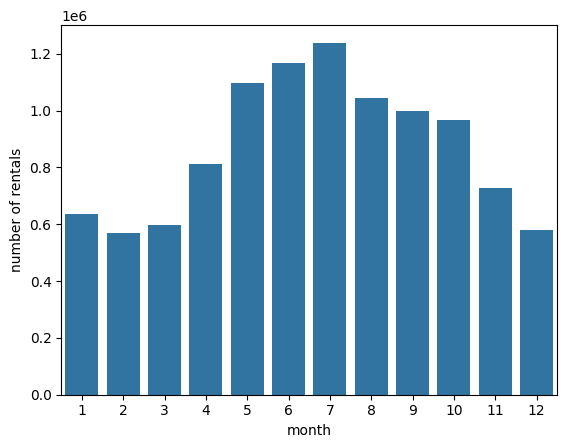

In [11]:
#small test: the number of rental events in the months of a particular year, say 2018
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

ax=sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])
ax.set(ylabel='number of rentals')

<Axes: xlabel='hour'>

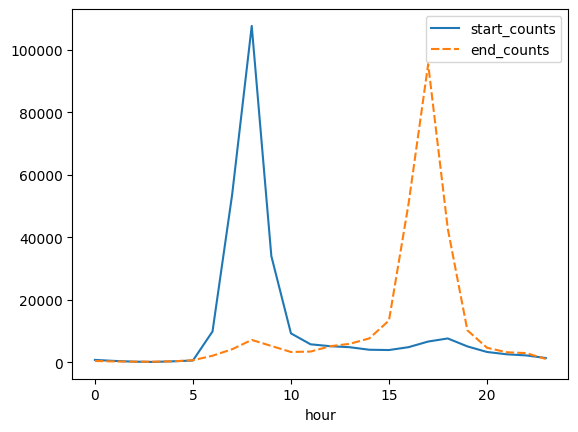

In [12]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)] # only weekdays for station 14
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

## The analysis

Although we might strongly suspect a correlation between weather and bike usage, I will first plot both their values to see if we see a (rough) correlation. This has still nothing to do with the data-driven part

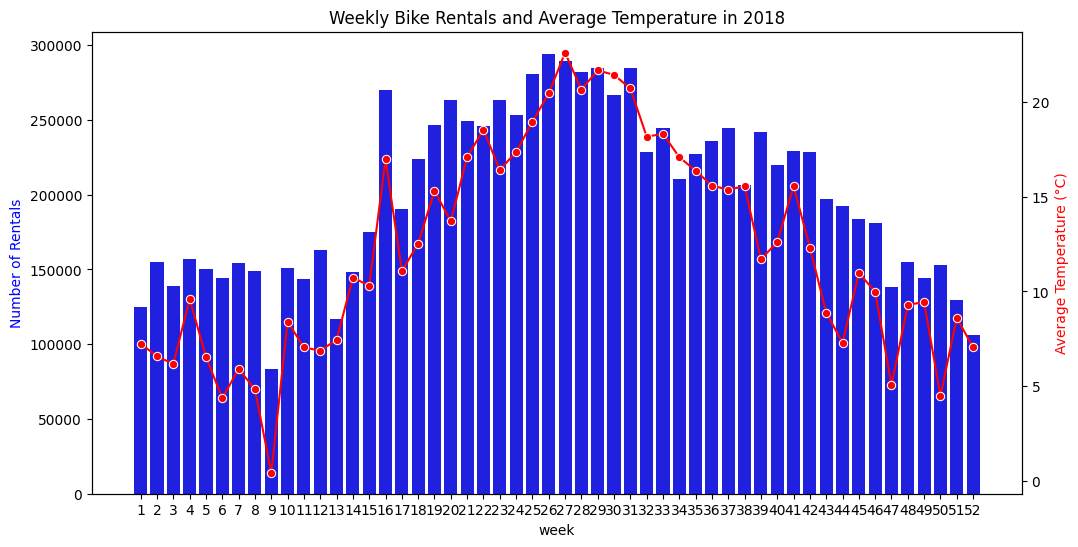

In [13]:
#Let's do it for each week in 2018
#Total number of bike rentals in the week:
per_week_2018_group = df_london.loc[df_london['year'] == 2018].groupby('week')
week_counts = per_week_2018_group.count()

# Compute the average temperature for each whole week of 2018
df_2018 = df_london_weather[df_london_weather['year'] == 2018]
avg_weekly_temp_2018 = df_2018.groupby('week')['tavg'].mean()

#Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=week_counts.index, y=week_counts.iloc[:,0], color='b', ax=ax1)
ax1.set_ylabel('Number of Rentals', color='b')

ax2 = ax1.twinx()
sns.lineplot(x=avg_weekly_temp_2018.index-1, y=avg_weekly_temp_2018, color='r', marker='o', ax=ax2)
ax2.set_ylabel('Average Temperature (°C)', color='r')

plt.title('Weekly Bike Rentals and Average Temperature in 2018')
plt.show()

I think we can conclude that there might definitely be a correlation between the average temperature and the number of bike rentals (clear for example in week 9 and 16)

### Just some ideas: 
We might see all weather-elements of a day as 'variables' and the number of bike-rides of a day as 'output'. We could do a PCA on these?

I don't know if we saw anything of this in class, but you might see all stations as nodes and the bikerides inbetween them as links. This way you can create a graph and show which stations are the most important (I mean from where to where is most driven), there is a kind of example of this in here: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131/

Creating a Neural Network to forecast the bike usage based on the data of the weather (of the same day, or maybe of the day before idk?)

Other ideas are welcome :)

### PCA on Weather data
I tried to get to 3 PCA's instead of 8. This gets us to 69,5%

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


start_data = df_london_weather.loc[:, 'tavg':'pres']
weather_features = start_data.columns.to_list()
n_features = len(weather_features)
start_data.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4


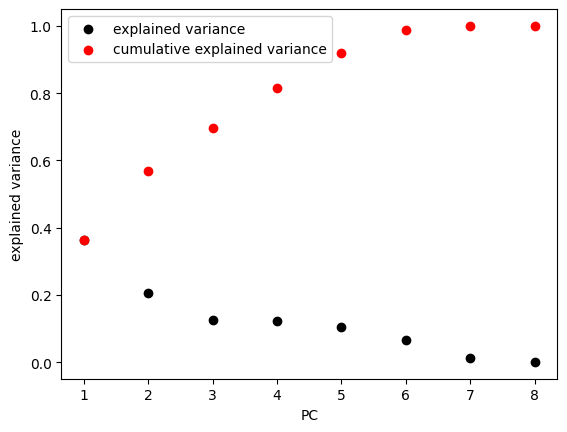

In [15]:
scaler = StandardScaler()
start_data_0 = scaler.fit_transform(start_data)

pca = PCA(n_components=n_features) #all featuresbecause we want to look at eigvals distribution
pca.fit_transform(start_data_0)

A = pca.components_.T
Z = start_data_0 @ A
ex_var = pca.explained_variance_ratio_
cum_ex_var = np.cumsum(ex_var)

plt.scatter(1+np.arange(n_features), ex_var, c='k', label='explained variance')
plt.scatter(1+np.arange(n_features), cum_ex_var, c='r', label='cumulative explained variance')
plt.xlabel('PC')
plt.ylabel('explained variance')
plt.legend()
plt.show()

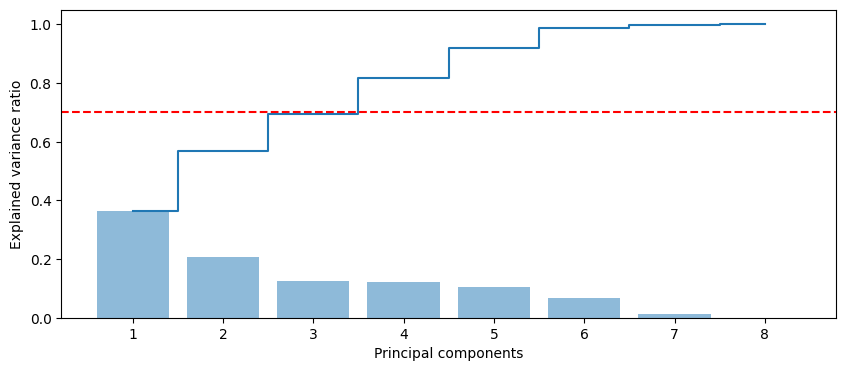

Explained variance per component:
PC1: 0.363 (0.363 cumulative)
PC2: 0.206 (0.569 cumulative)
PC3: 0.126 (0.695 cumulative)
PC4: 0.122 (0.817 cumulative)
PC5: 0.104 (0.920 cumulative)
PC6: 0.067 (0.987 cumulative)
PC7: 0.012 (0.999 cumulative)
PC8: 0.001 (1.000 cumulative)


In [16]:
# Fit PCA and examine explained variance
pca = PCA()
pca.fit(start_data_0)  # start_data_0 is your standardized weather data

# Plot the explained variance
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.axhline(y=0.7, color='r', linestyle='--')  # 70% variance threshold
plt.show()

# Print explained variance
print("Explained variance per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.3f} ({np.cumsum(pca.explained_variance_ratio_)[i]:.3f} cumulative)")

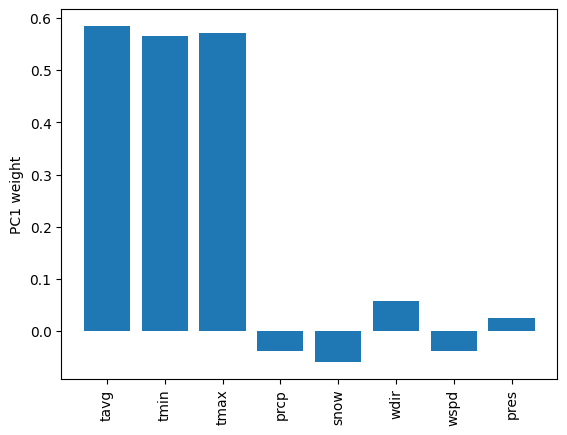

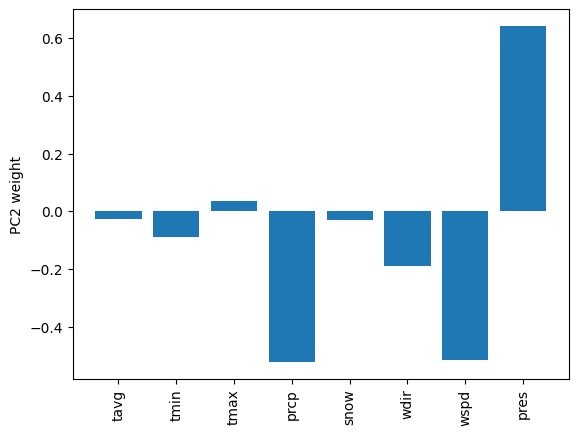

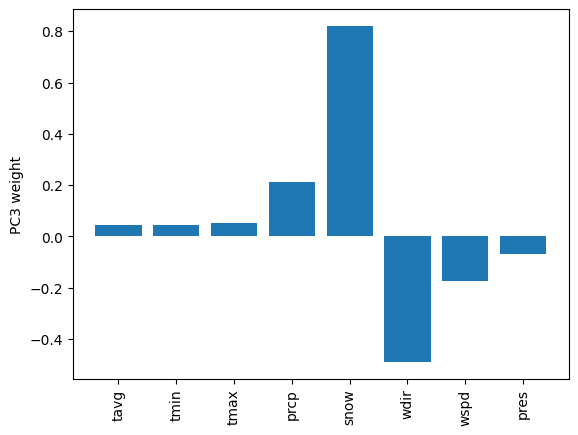

In [17]:
plt.bar(np.arange(n_features), A[:, 0])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC1 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 1])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC2 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 2])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC3 weight')
plt.show()

The clustering doesn't tell us much, but I did it anyway just to test

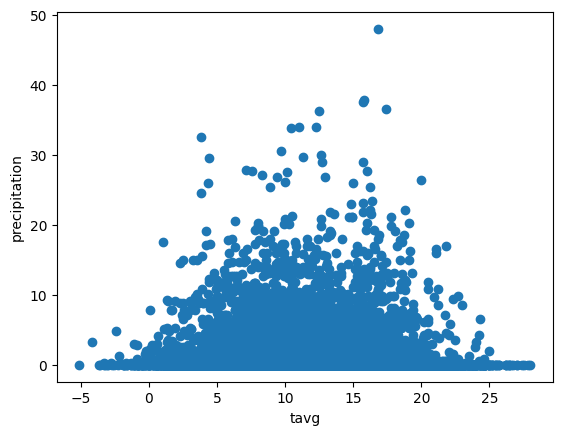

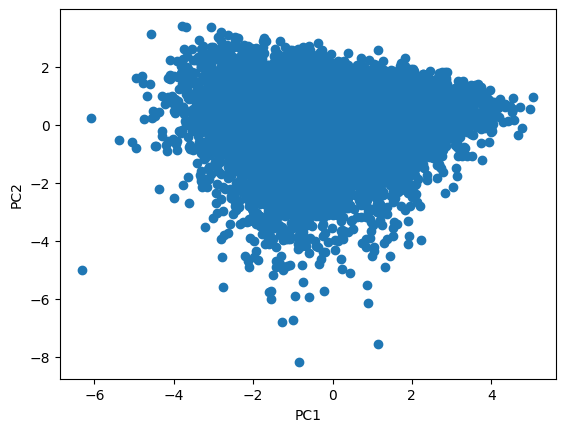

In [18]:
plt.scatter(start_data.loc[:, 'tavg'], start_data.loc[:, 'prcp']) #bad clustering
plt.xlabel('tavg')
plt.ylabel('precipitation')
plt.show()

plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show() #better clustering

### Data Integration:
Here we merge both database to find some correlation between them afterwards.

In [19]:
# Convert 'start_rental_date_time' to date (if not already done)
df_london['date'] = df_london['start_rental_date_time'].dt.date  

# Aggregate total rentals per day
daily_rentals = df_london.groupby('date').size().reset_index(name='rental_count')  
daily_rentals.head(3)  
# Ensure weather 'date' column is in date format (if not already done)
df_london_weather['date'] = pd.to_datetime(df_london_weather['date']).dt.date 

In [20]:
# Refit PCA with optimal number of components (3 PCA's)
n_optimal = 3  # Set based on explained variance plot
pca = PCA(n_components=n_optimal)
pca_transformed = pca.fit_transform(start_data_0)

# Create DataFrame with selected PCs
pca_df = pd.DataFrame(pca_transformed, columns=[f'weather_pc{i+1}' for i in range(n_optimal)])
pca_df['date'] = pd.to_datetime(df_london_weather['date']).dt.date

In [55]:
# First ensure we only keep PCA rows that match rental dates
# Get the dates that exist in both datasets
common_dates = set(daily_rentals['date']).intersection(set(pca_df['date']))

# Filter DataFrames
pca_df_filtered = pca_df[pca_df['date'].isin(common_dates)]
weather_df_filtered = df_london_weather[df_london_weather['date'].isin(common_dates)]
daily_rentals_filtered = daily_rentals[daily_rentals['date'].isin(common_dates)]
df_london_filtered = df_london[df_london['date'].isin(common_dates)]

In [22]:
# Merge on 'date'
merged_data = pd.merge(daily_rentals_filtered, pca_df_filtered, on='date', how='inner')  

# Verify lengths match
print(f"Bike rental records: {len(daily_rentals_filtered)}")
print(f"PCA weather records: {len(pca_df_filtered)}")
print(f"Merged records: {len(merged_data)}")

# Show PCA results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components kept:", pca.n_components_) 

merged_data.head(3)  

Bike rental records: 1344
PCA weather records: 1344
Merged records: 1344
Explained variance ratio: [0.36289502 0.20620928 0.1258539 ]
Number of components kept: 3


,date,rental_count,weather_pc1,weather_pc2,weather_pc3
0,2016-12-28,12387,-2.892950,3.012404,0.416180
1,2016-12-29,14012,-2.226310,2.742126,0.434245
2,2016-12-30,11537,-2.680771,2.031718,-0.602511



PCA Component Loadings:
         tavg      tmin      tmax      prcp      snow      wdir      wspd  \
PC1  0.584830  0.565740  0.572261 -0.038217 -0.060481  0.057023 -0.038569   
PC2 -0.025355 -0.090785  0.034818 -0.523547 -0.029569 -0.189304 -0.516478   
PC3  0.044191  0.044272  0.051879  0.212501  0.819861 -0.490528 -0.175087   

         pres  
PC1  0.023893  
PC2  0.642138  
PC3 -0.069233  


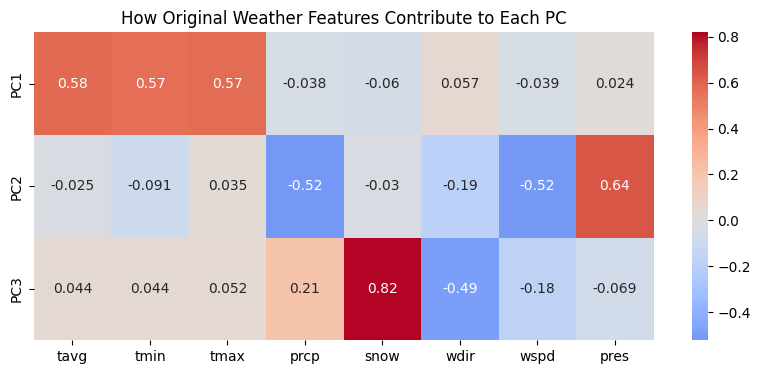

In [23]:
# Show how original features contribute to each PC (this is actually the same as the bar-plots before)
loadings = pd.DataFrame(
    pca.components_,
    columns=start_data.columns,
    index=[f'PC{i+1}' for i in range(n_optimal)]
)

print("\nPCA Component Loadings:")
print(loadings)

# Visualize loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True)
plt.title("How Original Weather Features Contribute to Each PC")
plt.show()

In [24]:
#Note Arthur: I believe this whole block is not very useful. It is not actually allowed to give meanings to PCA's

# Create loadings DataFrame with interpretation
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match standard format
    columns=['PC1', 'PC2', 'PC3'],
    index=start_data.columns
)

# Add interpretation notes (note Arthur: I think this is a bit wrong. PCA 1 Is pure Temp, PCA3 Only depends on snow and wdir, not pressure or temp)
interpretation = {
    'PC1': "Overall Weather Quality (Higher = Better)",
    'PC2': "Precipitation vs Wind Trade-off",
    'PC3': "Pressure/Temperature Anomaly"
}

# Print formatted results
print("="*60)
print("PCA COMPONENT LOADINGS (3 Components)")
print("="*60)
print(f"\nTotal Variance Explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"\nIndividual Components:")
for i in range(3):
    print(f"\nPC{i+1}: {interpretation[f'PC{i+1}']}")
    print(f"Variance Explained: {pca.explained_variance_ratio_[i]:.1%}")
    print(loadings.iloc[:, i].sort_values(ascending=False))
    
    # Print strongest drivers
    strongest_pos = loadings.iloc[:, i].nlargest(2).index.tolist()
    strongest_neg = loadings.iloc[:, i].nsmallest(2).index.tolist()
    print(f"\nStrongest Positive Drivers: {', '.join(strongest_pos)}")
    print(f"Strongest Negative Drivers: {', '.join(strongest_neg)}")

PCA COMPONENT LOADINGS (3 Components)

Total Variance Explained: 69.5%

Individual Components:

PC1: Overall Weather Quality (Higher = Better)
Variance Explained: 36.3%
tavg    0.584830
tmax    0.572261
tmin    0.565740
wdir    0.057023
pres    0.023893
prcp   -0.038217
wspd   -0.038569
snow   -0.060481
Name: PC1, dtype: float64

Strongest Positive Drivers: tavg, tmax
Strongest Negative Drivers: snow, wspd

PC2: Precipitation vs Wind Trade-off
Variance Explained: 20.6%
pres    0.642138
tmax    0.034818
tavg   -0.025355
snow   -0.029569
tmin   -0.090785
wdir   -0.189304
wspd   -0.516478
prcp   -0.523547
Name: PC2, dtype: float64

Strongest Positive Drivers: pres, tmax
Strongest Negative Drivers: prcp, wspd

PC3: Pressure/Temperature Anomaly
Variance Explained: 12.6%
snow    0.819861
prcp    0.212501
tmax    0.051879
tmin    0.044272
tavg    0.044191
pres   -0.069233
wspd   -0.175087
wdir   -0.490528
Name: PC3, dtype: float64

Strongest Positive Drivers: snow, prcp
Strongest Negative Dri

### Correlation
Between the number of bikes rented and the different weather variables

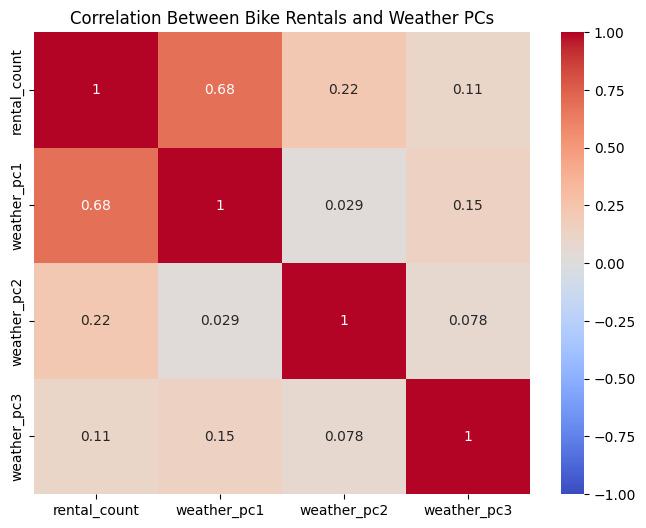


Correlation Interpretation:
weather_pc1: 0.684 (positive correlation)
weather_pc2: 0.220 (positive correlation)
weather_pc3: 0.106 (positive correlation)


In [25]:
# Correlation matrix between rentals and PCs
correlations = merged_data[['rental_count', 'weather_pc1', 'weather_pc2', 'weather_pc3']].corr()
# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Between Bike Rentals and Weather PCs")
plt.show() 

# Print interpretation
print("\nCorrelation Interpretation:")
for pc in [f'weather_pc{i+1}' for i in range(n_optimal)]:
    corr = correlations.loc['rental_count', pc]
    print(f"{pc}: {corr:.3f} ({'positive' if corr > 0 else 'negative'} correlation)")


Key Insights:
- weather_pc1: strong increases rentals (r = 0.68)
- weather_pc2: weak increases rentals (r = 0.22)
- weather_pc3: weak increases rentals (r = 0.11)


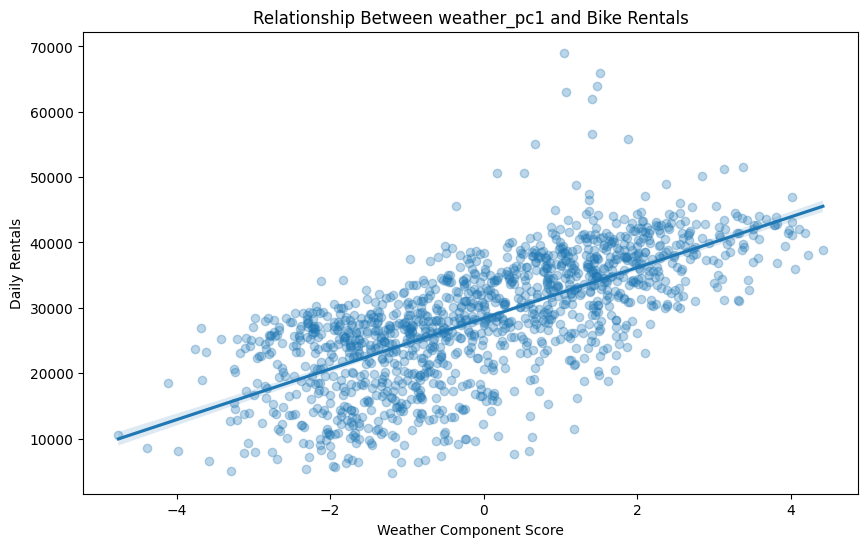

In [26]:
# Interpret the strongest correlations
print("\nKey Insights:")
for pc in ['weather_pc1', 'weather_pc2', 'weather_pc3']:
    corr = correlations.loc['rental_count', pc]
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"- {pc}: {strength} {direction} rentals (r = {corr:.2f})")

# Scatter plots for top correlations
top_pc = correlations.loc['rental_count'][1:].abs().idxmax()
plt.figure(figsize=(10, 6))
sns.regplot(x=top_pc, y='rental_count', data=merged_data, scatter_kws={'alpha':0.3})
plt.title(f"Relationship Between {top_pc} and Bike Rentals")
plt.xlabel("Weather Component Score")
plt.ylabel("Daily Rentals")
plt.show()

### Regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

selected_columns = ['tavg', 'tmin','tmax',	'prcp',	'snow',	'wdir',	'wspd',	'pres',	'date']
merged_rentals_weather = pd.merge(daily_rentals_filtered, weather_df_filtered.loc[:, selected_columns], on='date', how='inner')
X = merged_rentals_weather.loc[:, 'tavg':'pres']
Y = merged_rentals_weather.loc[:, 'rental_count']
dates = merged_rentals_weather.loc[:, 'date']

# create the test and train datasets
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(X, Y, dates, test_size=0.2, random_state=1)

# scale and center the data
scalerX = StandardScaler()

X0_train = scalerX.fit_transform(X_train)

#### Least-squares
A general regression problem can be written as: $y = f(\mathbf{x})$  with $y \in \mathbb{R}$, $x \in \mathbb{R}^d$ and $f: \mathbb{R}^d \mapsto \mathbb{R}$.
In linear regression, the function is represented by an array of weights: $y = \mathbf{w}^T \mathbf{x} = \sum_{i}^d w_i x_i$.

We need to tune the weights to our process, so we collect some data on the inputs $\mathbf{x}$ and the target $y$. The objective is to tune the weights to minimize the euclidean distance between the observations $\mathbf{y} \in \mathbb{R}^n$ and the predictions $\mathbf{X} \mathbf{w}$:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2$

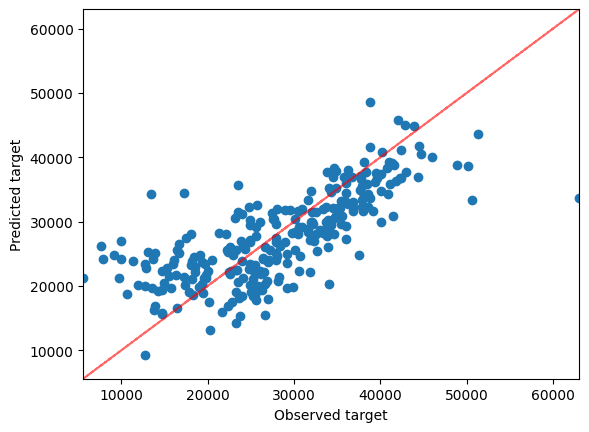

R2 for OLS is: 0.55
MSE for OLS is: 40266262.02
RMSE for OLS is: 6345.57


In [28]:
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the linear regression object
OLS_reg = LinearRegression().fit(X0_train, y_train)

# To test the regression, we need to scale and center also the test data
X0_test = scalerX.transform(X_test)
y_pred_OLS = OLS_reg.predict(X0_test)

plt.scatter(y_test, y_pred_OLS)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-5, y_test.max()+5)
plt.ylim(y_test.min()-5, y_test.max()+5)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

r2_ols = r2_score(y_test, y_pred_OLS)
mse_ols = mean_squared_error(y_test, y_pred_OLS)
rmse_ols = root_mean_squared_error(y_test, y_pred_OLS)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'MSE for OLS is: {mse_ols:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')

#### Lasso regression with cross validation

In the OLS regression model we have included all the input features. However, if some features are not correlated with the output this can decrease the accuracy of the model. The LASSO regression model penalizes the coefficients that are different from zero, forcing the weights to be active only if they improve the model.

The objective function of the LASSO regression problem is:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} \frac{1}{2 n} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2 + \alpha ||\mathbf{w}||_1$

In which the coefficient $\alpha$ controls how much we regularize the model.

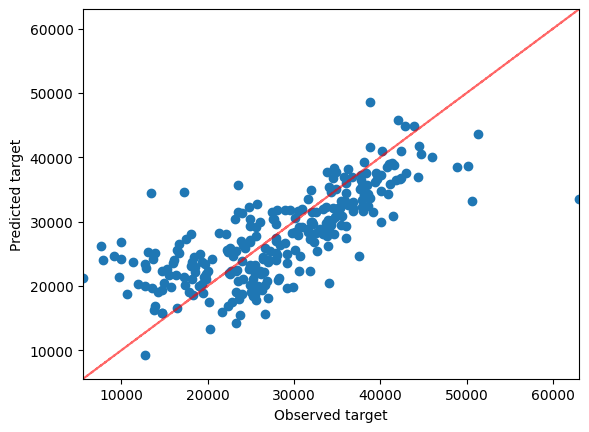

LS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
LassoCV coefficients: 
[ 7127.284 -4122.598  3415.43   -218.727  -165.586   338.219  -747.129
   827.728]
R2 for OLS is: 0.55
R2 for LassoCV is: 0.55
RMSE for OLS is: 6345.57
RMSE for LassoCV is: 6344.33
alpha = 6.88


In [29]:
from sklearn.linear_model import LassoCV

LassoCV_reg = LassoCV(cv=5, random_state=42).fit(X0_train, y_train)
y_pred_lassoCV = LassoCV_reg.predict(X0_test)

plt.scatter(y_test, y_pred_lassoCV)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

print('LS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('LassoCV coefficients: ')
print(np.round(LassoCV_reg.coef_, 3))

r2_lassoCV = r2_score(y_test, y_pred_lassoCV)
rmse_lassoCV = root_mean_squared_error(y_test, y_pred_lassoCV)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for LassoCV is: {r2_lassoCV:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for LassoCV is: {rmse_lassoCV:.2f}')

print(f'alpha = {LassoCV_reg.alpha_:.2f}')

Conclusion: doesn't change that much

#### Ridge regression

In Ridge regression, the regularization is applied to the $l_2$ norm of the weights. We want to reduce the magnitude of the weights, so that the model is less sensitive to noise.
The objective function of a Ridge regression problem is:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2 + \alpha ||\mathbf{w}||_2$

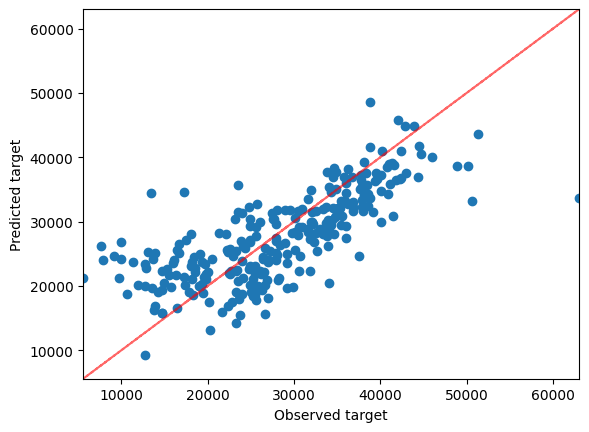

OLS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
RidgeCV coefficients: 
[ 7054.762 -4122.852  3488.668  -222.849  -171.301   347.08   -748.71
   826.256]
R2 for OLS is: 0.55
R2 for RidgeCV is: 0.55
RMSE for OLS is: 6345.57
RMSE for RidgeCV is: 6342.62
alpha = 1.00


In [30]:
from sklearn.linear_model import RidgeCV

RidgeCV_reg = RidgeCV(alphas=(0.1, 0.5, 1, 5, 10, 50), cv=5).fit(X0_train, y_train)
y_pred_RidgeCV = RidgeCV_reg.predict(X0_test)
y_pred_RidgeCV_train = RidgeCV_reg.predict(X0_train) #not for computing values, but for prediction using regression (see next block)

plt.scatter(y_test, y_pred_RidgeCV)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

print('OLS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('RidgeCV coefficients: ')
print(np.round(RidgeCV_reg.coef_, 3))

r2_ridgeCV = r2_score(y_test, y_pred_RidgeCV)
rmse_ridgeCV = root_mean_squared_error(y_test, y_pred_RidgeCV)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for RidgeCV is: {r2_ridgeCV:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for RidgeCV is: {rmse_ridgeCV:.2f}')

print(f'alpha = {RidgeCV_reg.alpha_:.2f}')

Doesn't change much, but this is the best result up to now. But if we use it for prediction, it is clearly not okay

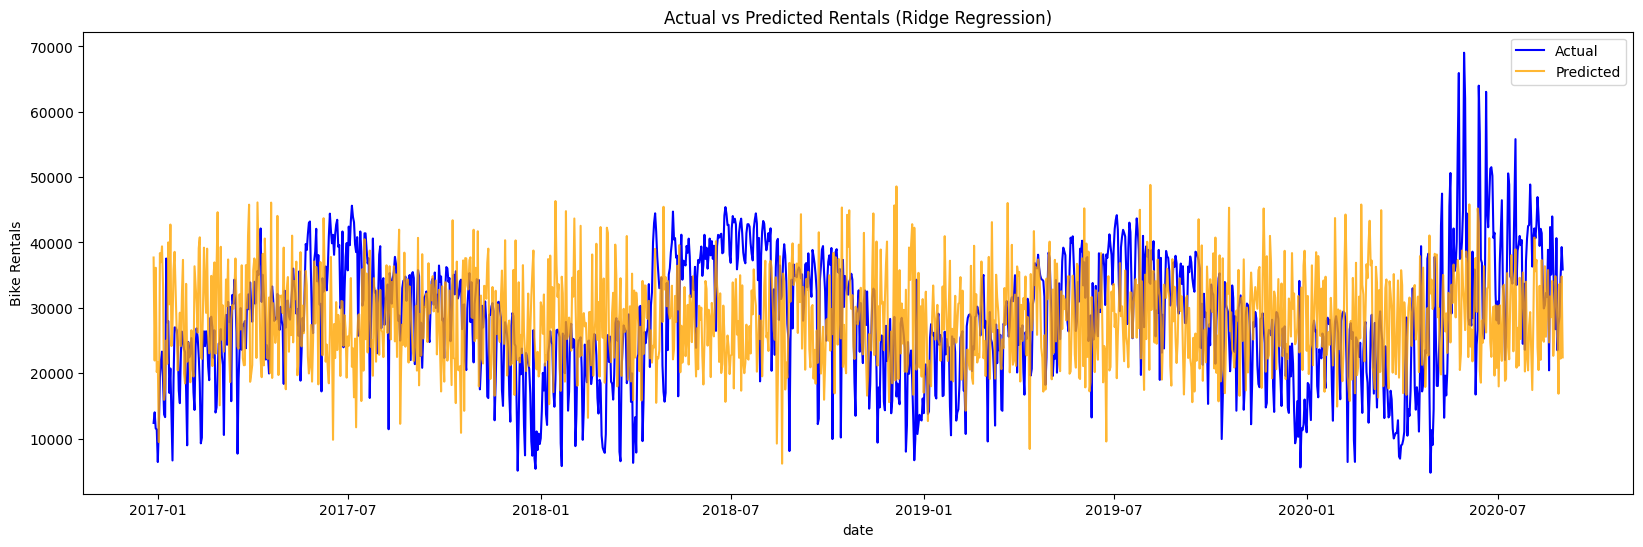

In [31]:
df = df = pd.DataFrame({'date': dates, 'y_true': Y})
df['y_pred'] = np.nan
df.loc[df['date'].isin(date_train), 'y_pred'] = y_pred_RidgeCV_train
df.loc[df['date'].isin(date_test), 'y_pred'] = y_pred_RidgeCV

# Plot actual vs predicted
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='date', y='y_true', label='Actual', color='blue', alpha=1)
sns.lineplot(data=df, x='date', y='y_pred', label='Predicted', color='orange', alpha=0.8)
plt.title("Actual vs Predicted Rentals (Ridge Regression)")
plt.ylabel("Bike Rentals")
plt.legend()
plt.show()

#### Principal components regression

The principal component regression is the same as the OLS regression, with an extra-step: the PCA is applied to the X matrix, and the linear regression is performed on the new projected data.

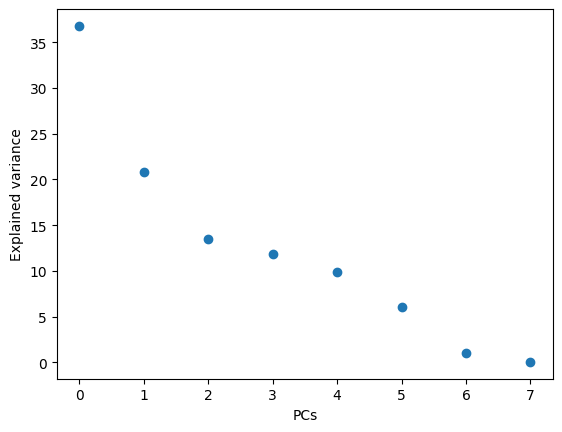

In [32]:
from sklearn.decomposition import PCA

pca = PCA().fit(X0_train)

plt.scatter(np.arange(X.shape[1]), pca.explained_variance_ratio_*100)
plt.xlabel('PCs')
plt.ylabel('Explained variance')
plt.show()

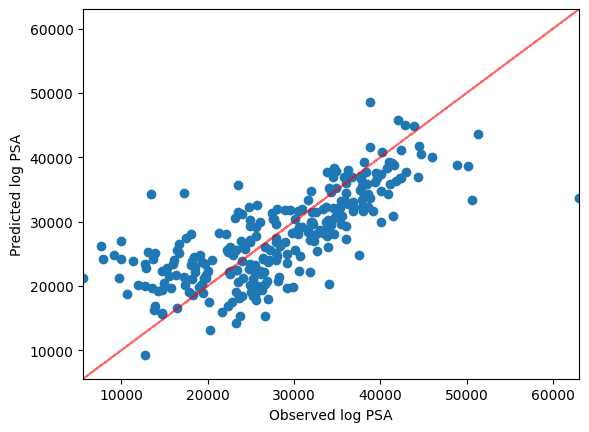

LS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
PCR coefficients: 
[ 3868.243  1347.984  -180.545   -66.226   567.114   226.791 -5785.109
  7030.069]
R2 for OLS is: 0.55
R2 for PCR is: 0.55
RMSE for OLS is: 6345.57
RMSE for PCR is: 6345.57


In [33]:
A_train = pca.components_.T
Z_train = X0_train @ A_train
Z_test = X0_test @ A_train

# The regression has to be applied to the PC scores
PCR_reg = LinearRegression().fit(Z_train, y_train)
y_pred_PCR = PCR_reg.predict(Z_test)

plt.scatter(y_test, y_pred_PCR)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed log PSA')
plt.ylabel('Predicted log PSA')
plt.show()

print('LS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('PCR coefficients: ')
print(np.round(PCR_reg.coef_, 3))

r2_pcr = r2_score(y_test, y_pred_PCR)
rmse_PCR = root_mean_squared_error(y_test, y_pred_PCR)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for PCR is: {r2_pcr:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for PCR is: {rmse_PCR:.2f}')

# This is still exactly the same as OLS, because we take all PC's

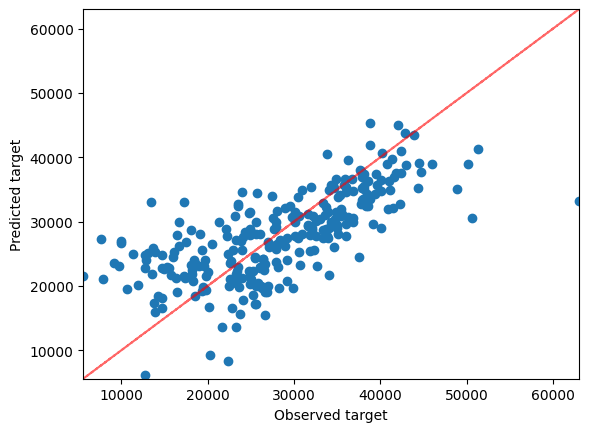

R2 for OLS is: 0.55
R2 for PCR is: 0.49
RMSE for OLS is: 6345.57
RMSE for PCR is: 6790.15


In [34]:
# We can test the regression with fewer features, let's say 3
q = 3
Z_train = X0_train @ A_train[:,:q]
Z_test = X0_test @ A_train[:,:q]

PCR_reg = LinearRegression().fit(Z_train, y_train)
y_pred_PCR = PCR_reg.predict(Z_test)
y_pred_PCR_trained = PCR_reg.predict(Z_train) #This is not to compute our values, but to see how our regression works in prediction (see next block)

plt.scatter(y_test, y_pred_PCR)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

r2_pcr = r2_score(y_test, y_pred_PCR)
rmse_PCR = root_mean_squared_error(y_test, y_pred_PCR)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for PCR is: {r2_pcr:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for PCR is: {rmse_PCR:.2f}')

Ofcourse this is 'worse', but we only take into account 3 out of 8 PC's, so it is actually kind of okay I would say

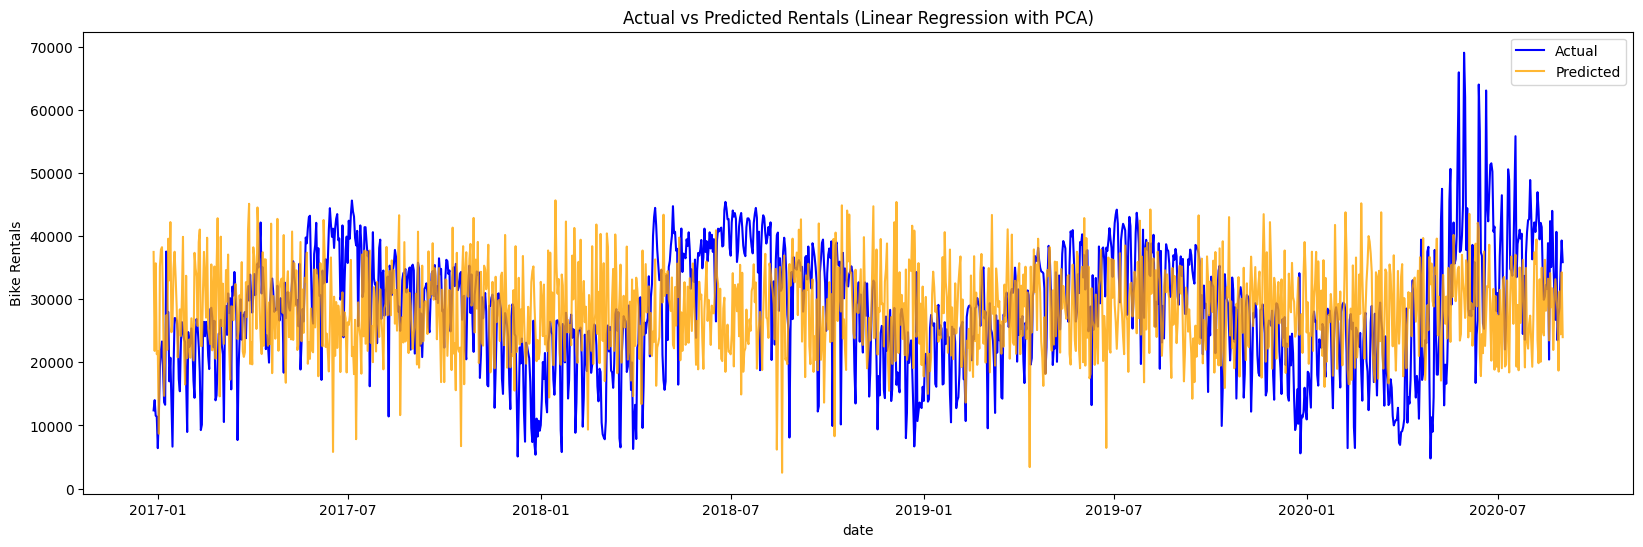

In [35]:
df = df = pd.DataFrame({'date': dates, 'y_true': Y})
df['y_pred'] = np.nan
df.loc[df['date'].isin(date_train), 'y_pred'] = y_pred_PCR_trained
df.loc[df['date'].isin(date_test), 'y_pred'] = y_pred_PCR

# Plot actual vs predicted
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='date', y='y_true', label='Actual', color='blue', alpha=1)
sns.lineplot(data=df, x='date', y='y_pred', label='Predicted', color='orange', alpha=0.8)
plt.title("Actual vs Predicted Rentals (Linear Regression with PCA)")
plt.ylabel("Bike Rentals")
plt.legend()
plt.show()

Clearly, we don't have very good results with this :)

### Neural Networks
    
So I guess we could also try a neural network to learn the weather and bike behavior and predicting future cases since it's probably better than a linear regression (non-linear behavior) and for more complex relation, since bike rentals are influenced by more complex, non-linear factors such as combinations of weather conditions, time of year, and human behavior patterns.

In this section, I will try to make a Neural Network using Keras library, training on historical data (part of all data splitted) and evaluating the performance.

Note: Tensorflow depends on the python version you use (newest version is not supported yet), I had to download Python 3.11.8 for this

In [36]:
#pip install tensorflow==2.15.0

#### Neural Network only based on 3 weather criteria
    
Avg temp, precipitation & wind speed


Full dataset size: 1344
x_train: (940, 3)
x_test: (404, 3)
y_train_scaled (940, 1)




Time it took: 6 seconds.
Train MSE: 0.4597
Validation MSE: 0.5226


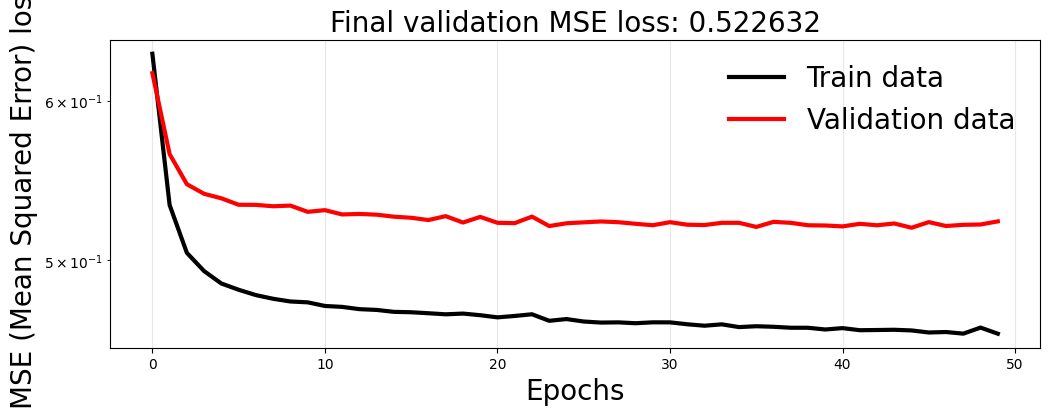

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import time

#Depending on the features we want to feed to our network, define the features:
features = ['tavg', 'prcp', 'wspd']
#Also define the target (dependent variable we want to predict)
target = 'rental_count'

#print(merged_rentals_weather)
#We extract these from the merged dataframe:
x = merged_rentals_weather[features]
y = merged_rentals_weather[target]

print("Full dataset size:", x.shape[0])

x_train, x_test, y_train, y_test, date_train, date_test = train_test_split(x, y, dates, test_size=0.3, random_state=100)

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)


#Scale the features and targets: (NN tend to work better on scaled data, was told)
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

#Reshape for scaling
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))  
print('y_train_scaled',y_train_scaled.shape)

#Now we define the neural network model:
#We'll start with a feedforward NN (simplest one haha)
#Sequential: creates linear stack of layers, Dense layer = fully connected neural network layer
#We create a 3x64x64x1 neural network, inputs=features, single output=rental count
#ReLU is a default choice for activation functions due to simplicity and efficiency

#Note Arthur: This is a 3x32x16x1 network I believe? I wrote a 64x64 below, but this is actually worse

model = Sequential([
    Dense(32, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1) #Output layer
])
"""
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1) #Output layer
])
"""

#Configure the neural network for training: (metrics=performance tracker)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#We will record the time of training it took:
tic = time.perf_counter()

#Training the model for a fixed number of epochs:
#batch_size = amount of samples passed through the model before updating the weights once
#epochs = amount of times the model goes through the whole dataset
history = model.fit(x_train_scaled, y_train_scaled, batch_size=64, epochs=50, validation_data=(x_test_scaled,y_test_scaled), verbose=0)

toc = time.perf_counter()
print('Time it took: ' + str(int(toc-tic)) + ' seconds.')

#Evaluate the model:
#We can check both the train loss and validation loss evolution = error on the training data and error on unseen validation data (how well do we generalize wrt new data)

def plot_nn_diagnostics(history):

    fig = plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], 'k-', lw=3, label='Train data')
    plt.plot(history.history['val_loss'], 'r-', lw=3, label='Validation data')
    plt.ylabel('MSE (Mean Squared Error) loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(alpha=0.3)
    plt.title('Final validation MSE loss: ' + str(round(history.history['val_loss'][-1],6)), fontsize=20)
    plt.legend(fontsize=20, frameon=False)
    plt.yscale('log')
    
    return plt

plot_nn_diagnostics(history)
print(f"Train MSE: {history.history['loss'][-1]:.4f}")
print(f"Validation MSE: {history.history['val_loss'][-1]:.4f}")

We observe that the neural network has not been optimized yet (still a quite present loss of 0.5) but for now: decreasing trend for more epochs and better values since we started in the 10^5 magnitude. Note: watch out for overfitting when handling complexity (neurons,...)

13/13 [==============================] - 0s 1ms/step


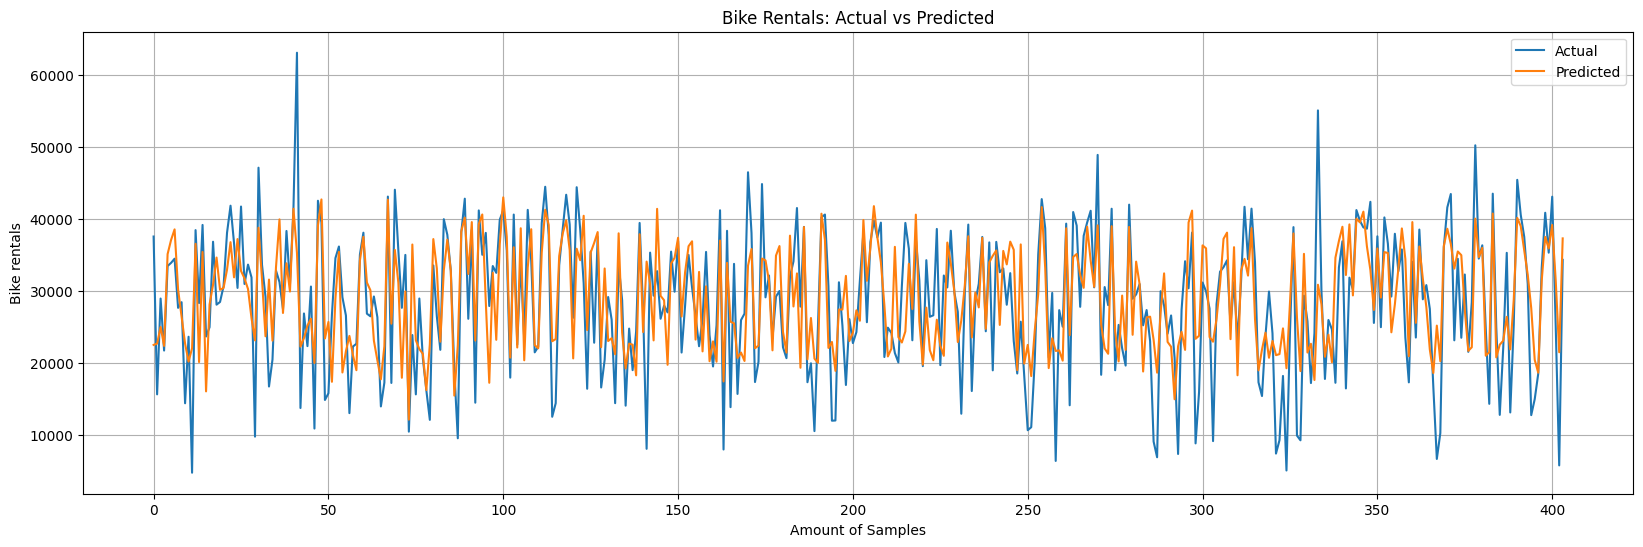

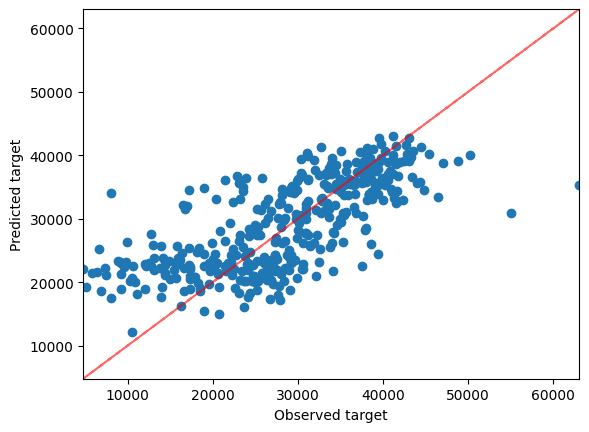

R2 for OLS is: 0.55
R2 for NN is: 0.51
RMSE for OLS is: 6345.57
RMSE for NN is: 6869.01


In [38]:
#Let's try to make a prediciton and plotting the results:
import numpy as np

y_prediction_scaled = model.predict(x_test_scaled)
#Important to unscale since we are working with scaled predictions
y_pred = y_scaler.inverse_transform(y_prediction_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(20,6))
#plt.plot(y_test_unscaled[:100], label='Actual') 
#plt.plot(y_pred[:100], label='Predicted')
plt.plot(y_test_unscaled, label='Actual') 
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Bike Rentals: Actual vs Predicted')
plt.xlabel('Amount of Samples')
plt.ylabel('Bike rentals')
plt.grid()
plt.show()

#Same test as before with the linear regressions
plt.scatter(y_test_unscaled, y_pred)
plt.plot(y_test_unscaled, y_test_unscaled, c='r', alpha=0.6, ls='--')
plt.xlim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.ylim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

r2_nn = r2_score(y_test_unscaled, y_pred)
rmse_nn = root_mean_squared_error(y_test_unscaled, y_pred)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for NN is: {r2_nn:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for NN is: {rmse_nn:.2f}')

Note Arthur: It is clear to me that we mostly train with data from 15000-45000. Because of that, in that rang you have very good results, but outside of these numbers you don't

That was a prediction for the test dataset (only 400 of 1300 samples). I have the feeling that is only a small amount for testing. Anyhow, since this went quite okay, now let's try to perform a prediction for the whole dataset (lot of commented code here, those are two versions still kind of figuring out what is best and why they are different):

Note Arthur: I believe the 1st is definitely right. However you should note that you trained the model with your training dataset, which is now aort of the whole x you are using the model on. So it might give you a wrong image on how well the model is predicting, since these training values will be predicted wayyy beter. Actually the plot above is the best to see it on, but this one here shows you better that it can follow trends (see the large wave)

42/42 [==============================] - 0s 2ms/step


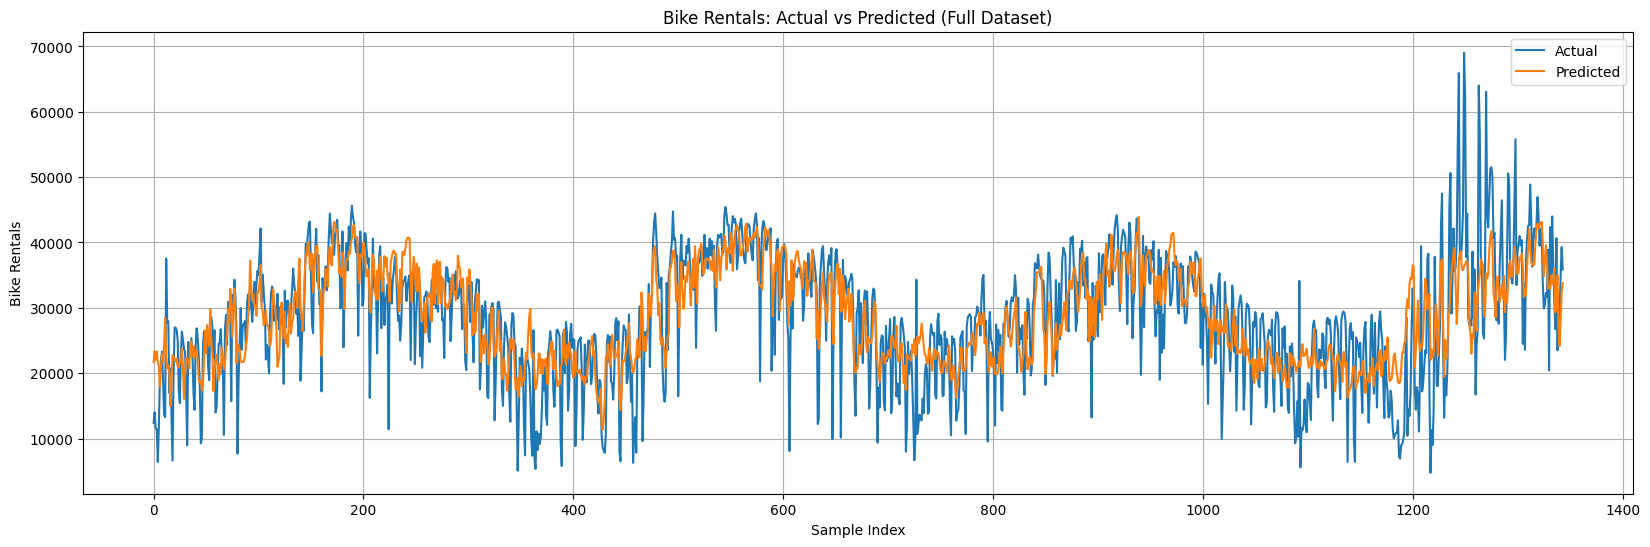

In [39]:
#first option

# Predict on the full dataset (in original order)
x_all_scaled = x_scaler.transform(x)
y_all_pred_scaled = model.predict(x_all_scaled)
y_all_pred = y_scaler.inverse_transform(y_all_pred_scaled)

# True values are already in original order
y_all_true = y.values

# Plot
plt.figure(figsize=(20,6))
plt.plot(y_all_true, label='Actual')
plt.plot(y_all_pred, label='Predicted')
plt.title('Bike Rentals: Actual vs Predicted (Full Dataset)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid()
plt.show()

Note Arthur: This one is wrong. (The order, not the prediction itself). You concatenate the arrays just next to each other, while in reality the test-data was plucked randomly from inbetween the whole data. So it should be placed back on those positions too. You can see this for example because usually (e.g. see above) the 7000-peaks are always at the end, while now, they are spread across the whole x-axis

13/13 [==============================] - 0s 3ms/step


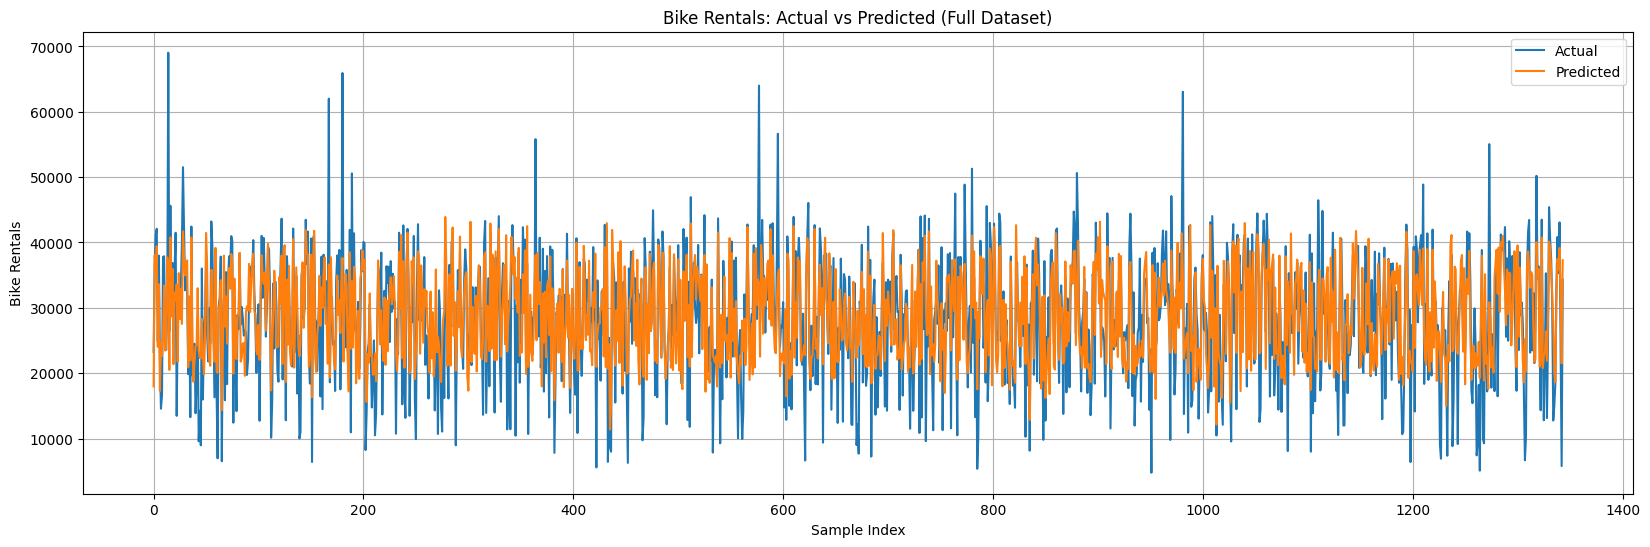

In [40]:
#second option:

# Predict on both training and test sets
y_train_pred_scaled = model.predict(x_train_scaled)
y_test_pred_scaled = model.predict(x_test_scaled)

# Inverse transform the predictions and true values, again since we everything scaled
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_train_unscaled = y_scaler.inverse_transform(y_train_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

# Concatenate to reach the full dataset again, crucial for plotting the whole set
y_all_true = np.concatenate([y_train_unscaled, y_test_unscaled])
y_all_pred = np.concatenate([y_train_pred, y_test_pred])

# Plot
plt.figure(figsize=(20,6))
plt.plot(y_all_true, label='Actual')
plt.plot(y_all_pred, label='Predicted')
plt.title('Bike Rentals: Actual vs Predicted (Full Dataset)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid()
plt.show()

A plot in function of the amount of samples is not very interesting, so let's attach the dates:

Note Arthur: You made this quite difficult for yourself. In this case, you could also just add "dates" as x and it would give the same. I did it below if you want an example

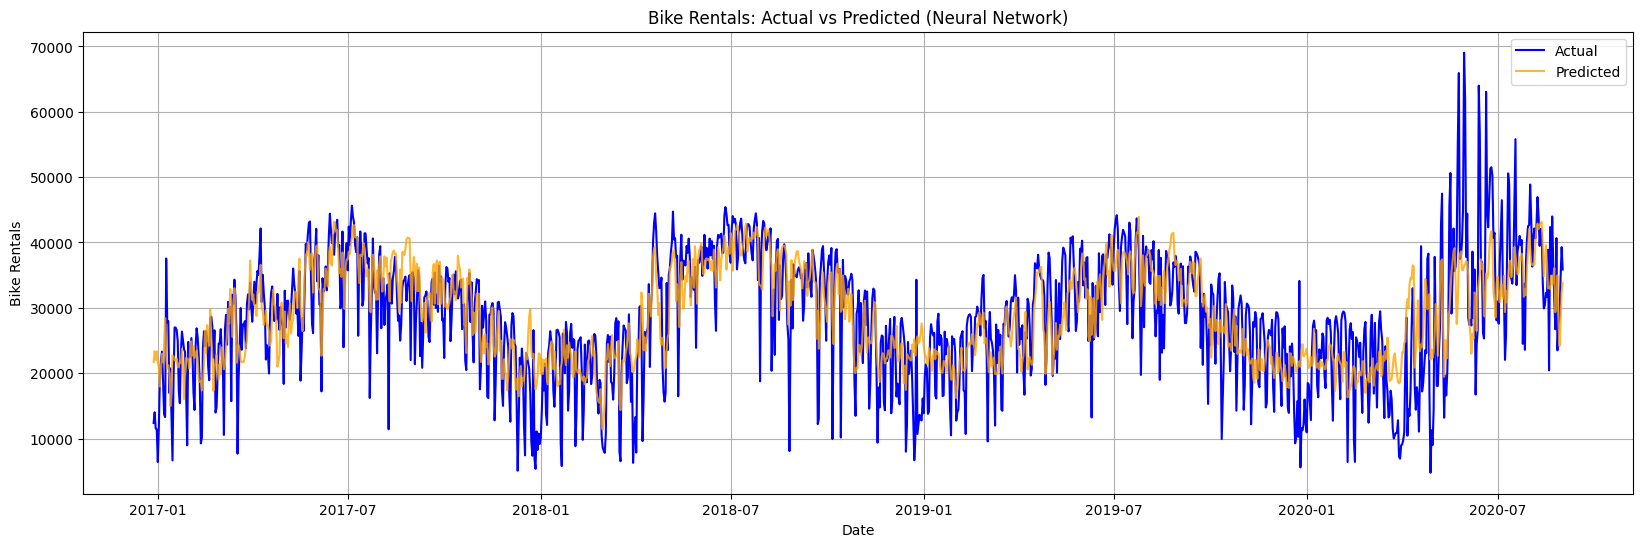

In [41]:
# Get the full date index and Y (true values)
full_dates = merged_rentals_weather['date']
Y_full = merged_rentals_weather['rental_count'].values

# Create empty DataFrame with full date and true values
df_plot = pd.DataFrame({
    'date': full_dates,
    'y_true': Y_full,
    'y_pred': np.nan
})

# Fill in predictions based on training and testing date indices
df_plot.loc[x_train.index, 'y_pred'] = y_train_pred
df_plot.loc[x_test.index, 'y_pred'] = y_test_pred

# Sort and plot (unnecessary but why not)
df_plot = df_plot.sort_values('date')

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_plot, x='date', y='y_true', label='Actual', color='blue', alpha=1)
sns.lineplot(data=df_plot, x='date', y='y_pred', label='Predicted', color='orange', alpha=0.8)
plt.title("Bike Rentals: Actual vs Predicted (Neural Network)")
plt.ylabel("Bike Rentals")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()



There's a mistake somewhere because it shouldn't be that patterns are different when plotting samples or dates.

Note Arthur: I don't see the difference

#### Neural Network based on all weather criteria

Full dataset size: 1344
x_train: (940, 7)
x_test: (404, 7)
y_train_scaled (940, 1)
Time it took: 5 seconds.
Train MSE: 0.3831
Validation MSE: 0.4848


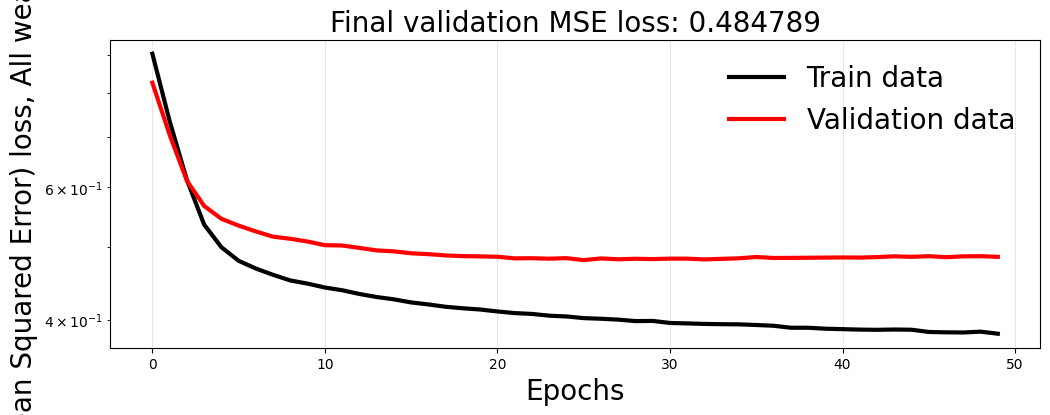

In [42]:
#ALL features:
features = ['tavg', 'tmin',  'tmax',    'snow',   'wdir',  'prcp', 'wspd']
#Also define the target (dependent variable we want to predict)
target = 'rental_count'

#We extract these from the merged dataframe:
x = merged_rentals_weather[features]
y = merged_rentals_weather[target]

print("Full dataset size:", x.shape[0])

x_train, x_test, y_train, y_test, date_train, date_test = train_test_split(x, y, dates, test_size=0.3, random_state=100)

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)


#Scale the features and targets: (NN tend to work better on scaled data, was told)
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

#Reshape for scaling
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))  
print('y_train_scaled',y_train_scaled.shape)

#Now we define the neural network model:
#We'll start with a feedforward NN (simplest one haha)
#Sequential: creates linear stack of layers, Dense layer = fully connected neural network layer
#We create a 3x32x16x1 neural network, inputs=features, single output=rental count
#ReLU is a default choice for activation functions due to simplicity and efficiency

model_2 = Sequential([
    Dense(32, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1) #Output layer
])

#Configure the neural network for training: (metrics=performance tracker)
model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

#We will record the time of training it took:
tic = time.perf_counter()

#Training the model for a fixed number of epochs:
#batch_size = amount of samples passed through the model before updating the weights once
#epochs = amount of times the model goes through the whole dataset
history = model_2.fit(x_train_scaled, y_train_scaled, batch_size=64, epochs=50, validation_data=(x_test_scaled,y_test_scaled), verbose=0)

toc = time.perf_counter()
print('Time it took: ' + str(int(toc-tic)) + ' seconds.')

#Evaluate the model:
#We can check both the train loss and validation loss evolution = error on the training data and error on unseen validation data (how well do we generalize wrt new data)

def plot_nn_diagnostics(history):

    fig = plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], 'k-', lw=3, label='Train data')
    plt.plot(history.history['val_loss'], 'r-', lw=3, label='Validation data')
    plt.ylabel('MSE (Mean Squared Error) loss, All weather data', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(alpha=0.3)
    plt.title('Final validation MSE loss: ' + str(round(history.history['val_loss'][-1],6)), fontsize=20)
    plt.legend(fontsize=20, frameon=False)
    plt.yscale('log')
    
    return plt

plot_nn_diagnostics(history)
print(f"Train MSE: {history.history['loss'][-1]:.4f}")
print(f"Validation MSE: {history.history['val_loss'][-1]:.4f}")

13/13 [==============================] - 0s 1ms/step


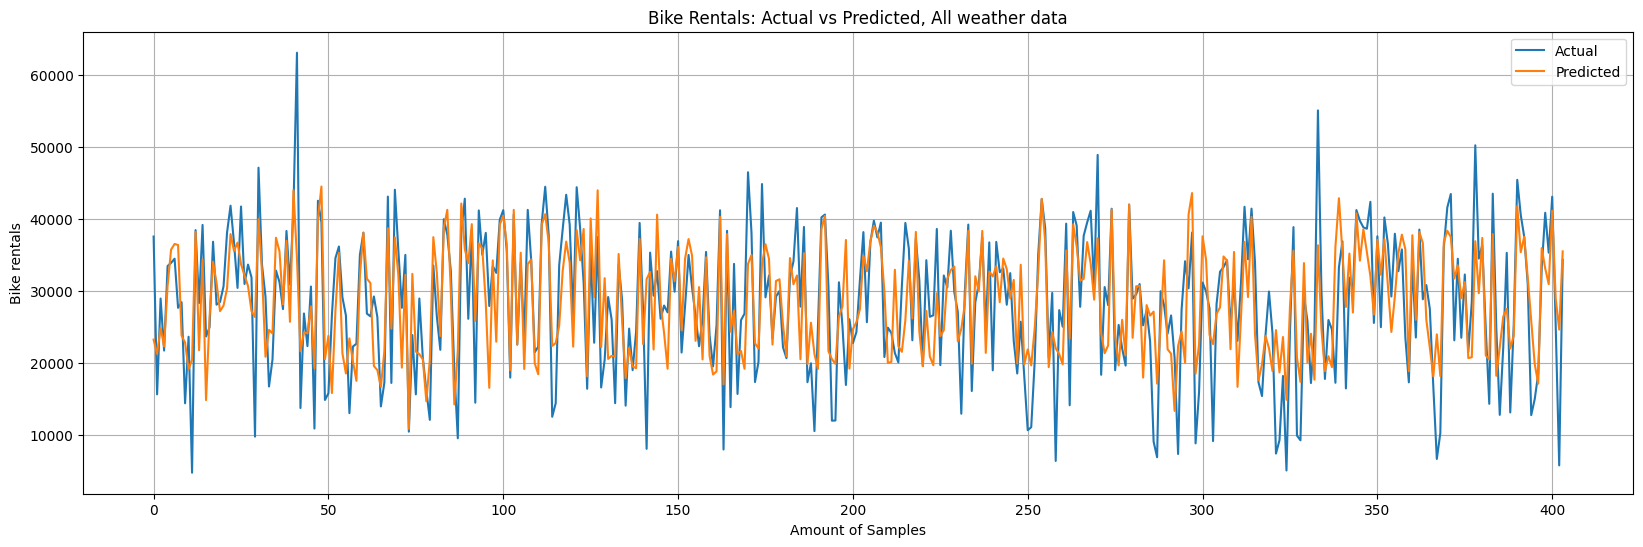

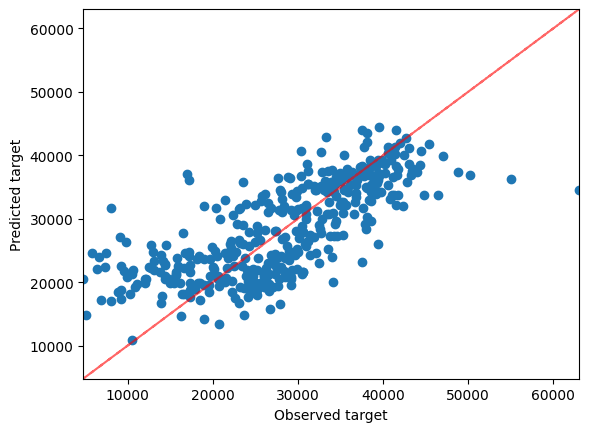

R2 for OLS is: 0.55
R2 for NN is: 0.54
RMSE for OLS is: 6345.57
RMSE for NN is: 6615.65


In [43]:
#Let's try to make a prediction and plotting the results:

y_prediction_scaled = model_2.predict(x_test_scaled)
#Important to unscale since we are working with scaled predictions
y_pred = y_scaler.inverse_transform(y_prediction_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(20,6))
#plt.plot(y_test_unscaled[:100], label='Actual') 
#plt.plot(y_pred[:100], label='Predicted')
plt.plot(y_test_unscaled, label='Actual') 
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Bike Rentals: Actual vs Predicted, All weather data')
plt.xlabel('Amount of Samples')
plt.ylabel('Bike rentals')
plt.grid()
plt.show()

#Same test as before with the linear regressions
plt.scatter(y_test_unscaled, y_pred)
plt.plot(y_test_unscaled, y_test_unscaled, c='r', alpha=0.6, ls='--')
plt.xlim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.ylim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

r2_nn = r2_score(y_test_unscaled, y_pred)
rmse_nn = root_mean_squared_error(y_test_unscaled, y_pred)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for NN is: {r2_nn:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for NN is: {rmse_nn:.2f}')

This is apparently a better result than before

42/42 [==============================] - 0s 2ms/step


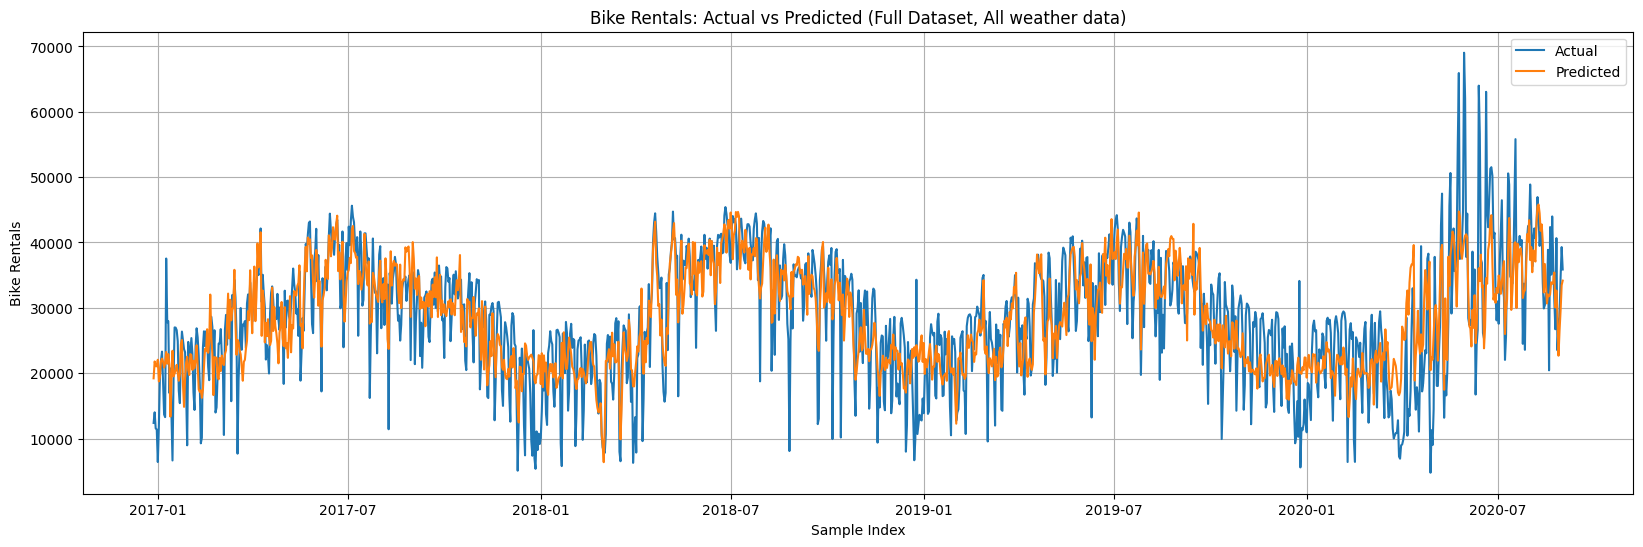

In [44]:
# Predict on the full dataset (in original order)
x_all_scaled = x_scaler.transform(x)
y_all_pred_scaled = model_2.predict(x_all_scaled)
y_all_pred = y_scaler.inverse_transform(y_all_pred_scaled)

# True values are already in original order
y_all_true = y.values

# Plot
plt.figure(figsize=(20,6))
plt.plot(dates, y_all_true, label='Actual')
plt.plot(dates, y_all_pred, label='Predicted')
plt.title('Bike Rentals: Actual vs Predicted (Full Dataset, All weather data)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid()
plt.show()

#### Neural network with weather AND day of week

Full dataset size: 1344
x_train: (940, 8)
x_test: (404, 8)
y_train_scaled (940, 1)
Time it took: 5 seconds.
Train MSE: 0.3061
Validation MSE: 0.3745


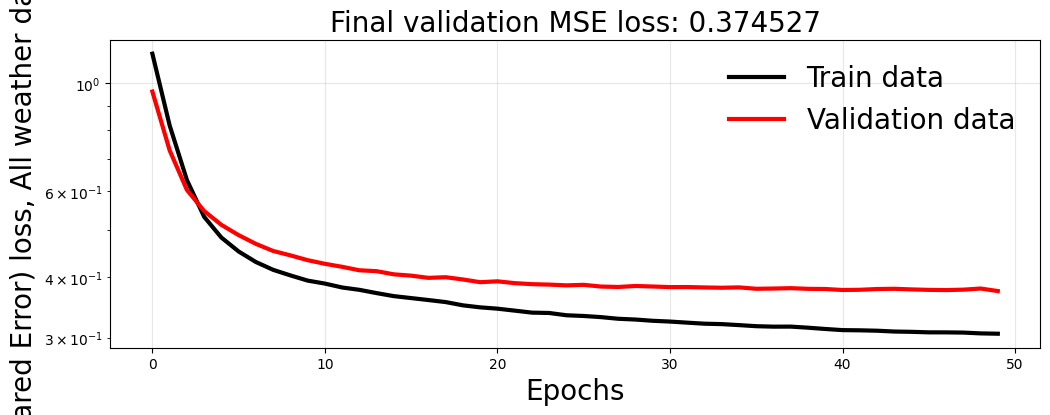

In [45]:
selected_columns = ['tavg', 'tmin','tmax',	'prcp',	'snow',	'wdir',	'wspd',	'pres',	'date', 'dayofweek']
merged_rentals_weather = pd.merge(daily_rentals_filtered, weather_df_filtered.loc[:, selected_columns], on='date', how='inner')
dates = merged_rentals_weather.loc[:, 'date']

#ALL features:
features = ['tavg', 'tmin',  'tmax',    'snow',   'wdir',  'prcp', 'wspd', 'dayofweek']
#Also define the target (dependent variable we want to predict)
target = 'rental_count'

#We extract these from the merged dataframe:
x = merged_rentals_weather[features]
y = merged_rentals_weather[target]

print("Full dataset size:", x.shape[0])

x_train, x_test, y_train, y_test, date_train, date_test = train_test_split(x, y, dates, test_size=0.3, random_state=100)

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)


#Scale the features and targets: (NN tend to work better on scaled data, was told)
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

#Reshape for scaling
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))  
print('y_train_scaled',y_train_scaled.shape)

#Now we define the neural network model:
#We'll start with a feedforward NN (simplest one haha)
#Sequential: creates linear stack of layers, Dense layer = fully connected neural network layer
#We create a 3x32x16x1 neural network, inputs=features, single output=rental count
#ReLU is a default choice for activation functions due to simplicity and efficiency

model_3 = Sequential([
    Dense(32, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1) #Output layer
])

#Configure the neural network for training: (metrics=performance tracker)
model_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

#We will record the time of training it took:
tic = time.perf_counter()

#Training the model for a fixed number of epochs:
#batch_size = amount of samples passed through the model before updating the weights once
#epochs = amount of times the model goes through the whole dataset
history = model_3.fit(x_train_scaled, y_train_scaled, batch_size=64, epochs=50, validation_data=(x_test_scaled,y_test_scaled), verbose=0)

toc = time.perf_counter()
print('Time it took: ' + str(int(toc-tic)) + ' seconds.')

#Evaluate the model:
#We can check both the train loss and validation loss evolution = error on the training data and error on unseen validation data (how well do we generalize wrt new data)

def plot_nn_diagnostics(history):

    fig = plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], 'k-', lw=3, label='Train data')
    plt.plot(history.history['val_loss'], 'r-', lw=3, label='Validation data')
    plt.ylabel('MSE (Mean Squared Error) loss, All weather data & day of week', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(alpha=0.3)
    plt.title('Final validation MSE loss: ' + str(round(history.history['val_loss'][-1],6)), fontsize=20)
    plt.legend(fontsize=20, frameon=False)
    plt.yscale('log')
    
    return plt

plot_nn_diagnostics(history)
print(f"Train MSE: {history.history['loss'][-1]:.4f}")
print(f"Validation MSE: {history.history['val_loss'][-1]:.4f}")

13/13 [==============================] - 0s 2ms/step


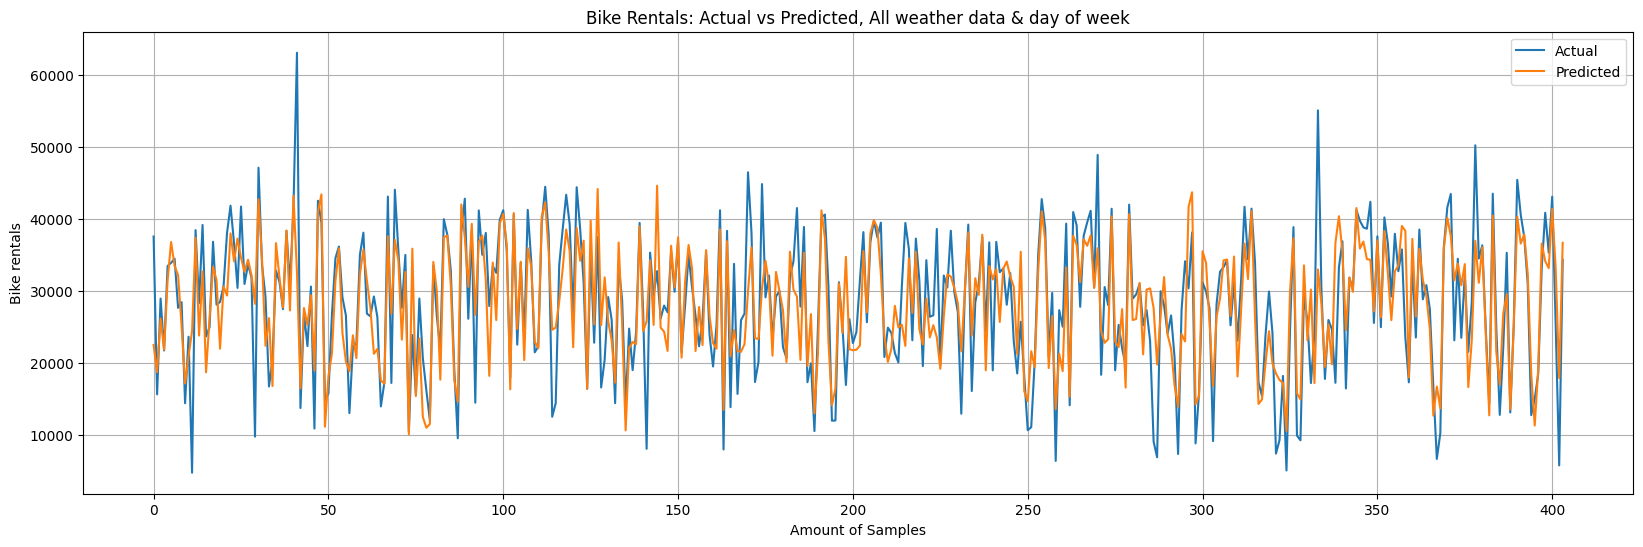

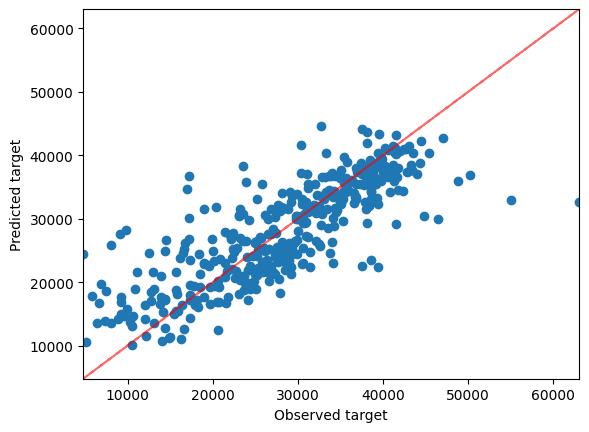

R2 for OLS is: 0.55
R2 for NN is: 0.65
RMSE for OLS is: 6345.57
RMSE for NN is: 5814.84


In [46]:
#Let's try to make a prediciton and plotting the results:
import numpy as np

y_prediction_scaled = model_3.predict(x_test_scaled)
#Important to unscale since we are working with scaled predictions
y_pred = y_scaler.inverse_transform(y_prediction_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(20,6))
#plt.plot(y_test_unscaled[:100], label='Actual') 
#plt.plot(y_pred[:100], label='Predicted')
plt.plot(y_test_unscaled, label='Actual') 
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Bike Rentals: Actual vs Predicted, All weather data & day of week')
plt.xlabel('Amount of Samples')
plt.ylabel('Bike rentals')
plt.grid()
plt.show()

#Same test as before with the linear regressions
plt.scatter(y_test_unscaled, y_pred)
plt.plot(y_test_unscaled, y_test_unscaled, c='r', alpha=0.6, ls='--')
plt.xlim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.ylim(y_test_unscaled.min()-1, y_test_unscaled.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

r2_nn = r2_score(y_test_unscaled, y_pred)
rmse_nn = root_mean_squared_error(y_test_unscaled, y_pred)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for NN is: {r2_nn:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for NN is: {rmse_nn:.2f}')

42/42 [==============================] - 0s 2ms/step


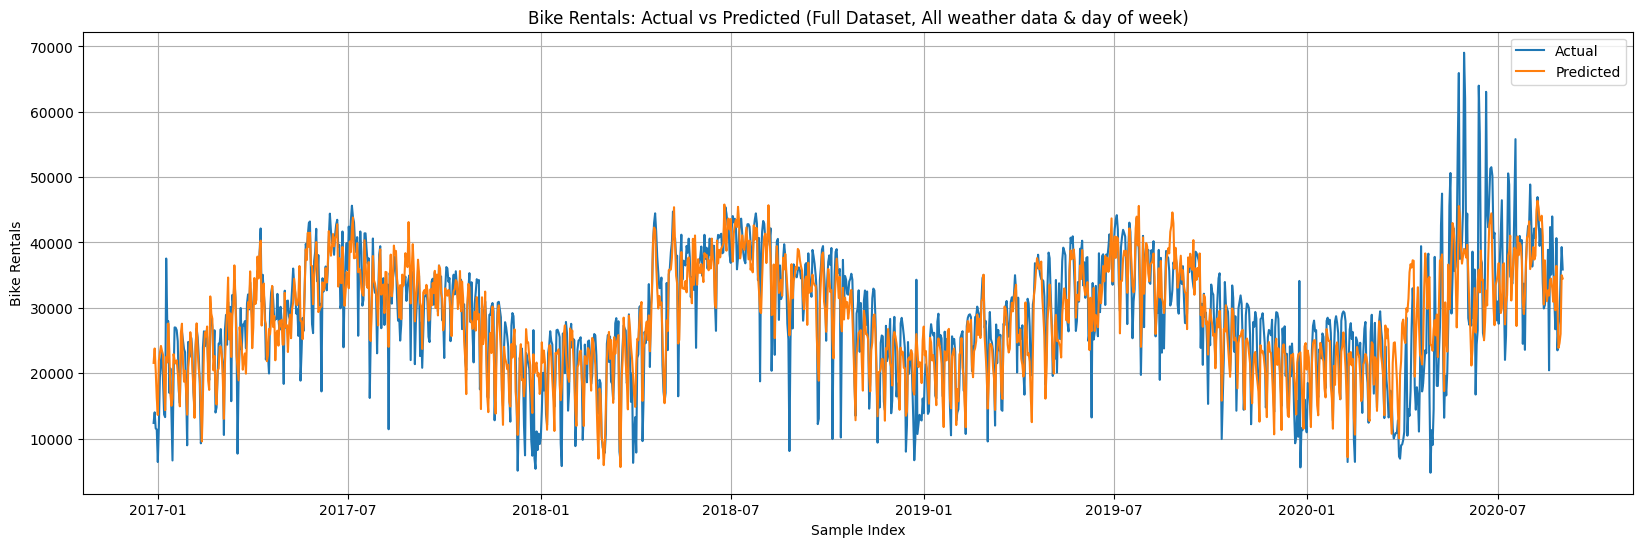

In [47]:
# Predict on the full dataset (in original order)
x_all_scaled = x_scaler.transform(x)
y_all_pred_scaled = model_3.predict(x_all_scaled)
y_all_pred = y_scaler.inverse_transform(y_all_pred_scaled)

# True values are already in original order
y_all_true = y.values

# Plot
plt.figure(figsize=(20,6))
plt.plot(dates, y_all_true, label='Actual')
plt.plot(dates, y_all_pred, label='Predicted')
plt.title('Bike Rentals: Actual vs Predicted (Full Dataset, All weather data & day of week)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid()
plt.show()

Training set size: 1343
Test set size (hold-out): 1

Training model...
Epoch 1/50


C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


21/21 [==============================] - 1s 2ms/step - loss: 0.9313 - mae: 0.7603
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.7042 - mae: 0.6528
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 0.5561 - mae: 0.5786
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 0.5055 - mae: 0.5613
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4970 - mae: 0.5555
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4923 - mae: 0.5521
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4882 - mae: 0.5505
Epoch 8/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4864 - mae: 0.5510
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4856 - mae: 0.5491
Epoch 10/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4818 - mae: 0.5460
Epoch 11/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4813 

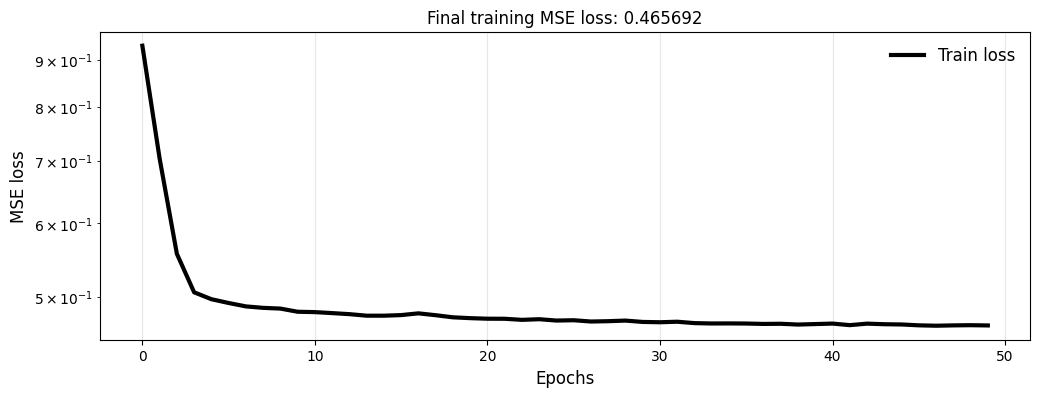

1/1 [==============================] - 0s 67ms/step

=== Prediction Results ===
Test Data Point Features:
tavg: 13.30
prcp: 0.00
wspd: 5.50

Actual rentals: 35863
Predicted rentals: 33348
Absolute difference: 2515
Percentage error: 7.0%

Feature importance (gradient analysis):
tavg: 0.3099
prcp: 0.0442
wspd: 0.1998


In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import time

# Define features and target
features = ['tavg', 'prcp', 'wspd']  # Temperature, Precipitation, Wind speed
target = 'rental_count'  # Make sure this matches your column name

# Extract features and target
x = merged_rentals_weather[features]
y = merged_rentals_weather[target]

# Hold out the last data point for validation
x_train = x.iloc[:-1]
y_train = y.iloc[:-1]
x_test = x.iloc[-1:].values.reshape(1, -1)  # Last data point
y_test = y.iloc[-1:]

print("Training set size:", x_train.shape[0])
print("Test set size (hold-out):", x_test.shape[0])

# Scale the features
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

# Scale the target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Define the neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
print("\nTraining model...")
tic = time.perf_counter()
history = model.fit(x_train_scaled, y_train_scaled, 
                   batch_size=64, 
                   epochs=50, 
                   verbose=1)
toc = time.perf_counter()
print(f'Training completed in {toc-tic:.2f} seconds')

# Plot training history
def plot_nn_diagnostics(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], 'k-', lw=3, label='Train loss')
    plt.ylabel('MSE loss', fontsize=12)
    plt.xlabel('Epochs', fontsize=12)
    plt.grid(alpha=0.3)
    plt.title(f'Final training MSE loss: {history.history["loss"][-1]:.6f}', fontsize=12)
    plt.legend(fontsize=12, frameon=False)
    plt.yscale('log')
    plt.show()

plot_nn_diagnostics(history)

# Make prediction on the held-out data point
y_pred_scaled = model.predict(x_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Print detailed comparison
print("\n=== Prediction Results ===")
print(f"Test Data Point Features:")
for i, feature in enumerate(features):
    print(f"{feature}: {x_test[0][i]:.2f}")

print(f"\nActual rentals: {y_test.values[0]:.0f}")
print(f"Predicted rentals: {y_pred[0][0]:.0f}")
print(f"Absolute difference: {abs(y_pred[0][0] - y_test.values[0]):.0f}")
print(f"Percentage error: {abs(y_pred[0][0] - y_test.values[0])/y_test.values[0]*100:.1f}%")

# Feature importance analysis
def get_feature_importance(model, x_sample):
    x_tensor = tf.convert_to_tensor(x_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y_pred = model(x_tensor)
    grads = tape.gradient(y_pred, x_tensor)
    return tf.reduce_mean(tf.abs(grads), axis=0)

# Calculate importance for a sample
try:
    sample_idx = 0
    importance = get_feature_importance(model, x_train_scaled[sample_idx:sample_idx+1])
    print("\nFeature importance (gradient analysis):")
    for i, feature in enumerate(features):
        print(f"{feature}: {importance[i]:.4f}")
except Exception as e:
    print(f"\nCould not calculate feature importance: {str(e)}")

In [ ]:
merged_stations_weather = pd.merge(df_london_filtered, weather_df_filtered.loc[:, selected_columns], on='date', how='inner')
dates = merged_stations_weather.loc[:, 'date']
merged_stations_weather.head(3)

Note Arthur: Make 2 arrays: one for the startings at King's Cross and one for the endings there. Inside of each of these arrays: Take together all counts for a certain hours of a day (like rental_counts, if you want an example). We should take these two arrays as 'target' now.

For the testing: look at previous examples of how we divided our data in test-and training data.

In [ ]:
# Filter data for King's Cross Station only

kings_cross_data = merged_stations_weather[
    (merged_stations_weather['start_station_name'].str.contains("Belgrove Street , King's Cross")) |
    (merged_stations_weather['end_station_name'].str.contains("Belgrove Street , King's Cross"))
]

selected_columns = ['end_station_name', 'start_station_name', 'year', 'month', 'day', 'hour', 'date','tavg', 'prcp', 'wspd']
kings_cross_data = kings_cross_data.loc[:, selected_columns]
kings_cross_data.head(7)

"""
kings_cross_data = merged_stations_weather[
    (merged_stations_weather['start_station_id'].str.contains("109")) |
    (merged_stations_weather['end_station_id'].str.contains("109"))
]
"""
# Define features and target
features = ['tavg', 'prcp', 'wspd', 'hour', 'dayofweek_y']  # Added temporal features
target = 'rental_count'

# Extract features and target
x = kings_cross_data[features]
y = kings_cross_data[target]

# Hold out last 7 days for testing (temporal validation)
test_size = 7*24  # 7 days * 24 hours
x_train = x.iloc[:-test_size]
y_train = y.iloc[:-test_size]
x_test = x.iloc[-test_size:]
y_test = y.iloc[-test_size:]

# Scale features
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Enhanced neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile with learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Add early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train-validation split
history = model.fit(x_train_scaled, y_train_scaled,
                   batch_size=32,
                   epochs=100,
                   validation_split=0.2,
                   callbacks=[early_stop],
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.show()

# Make predictions
y_pred_scaled = model.predict(x_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Create results dataframe
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred.flatten(),
    'Datetime': kings_cross_data.iloc[-test_size:]['start_rental_date_time']
})

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(results['Datetime'], results['Actual'], label='Actual Rentals')
plt.plot(results['Datetime'], results['Predicted'], label='Predicted Rentals')
plt.title("King's Cross Station - Actual vs Predicted Bike Rentals")
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate error metrics
mae = np.mean(np.abs(results['Actual'] - results['Predicted']))
rmse = np.sqrt(np.mean((results['Actual'] - results['Predicted'])**2))
print(f"\nKing's Cross Station Performance Metrics:")
print(f"MAE: {mae:.1f} rentals")
print(f"RMSE: {rmse:.1f} rentals")
print(f"Mean Actual Rentals: {np.mean(results['Actual']):.1f}")
print(f"Error Percentage: {mae/np.mean(results['Actual'])*100:.1f}%")

# Feature importance analysis
def get_feature_importance(model, x_sample, feature_names):
    x_tensor = tf.convert_to_tensor(x_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y_pred = model(x_tensor)
    grads = tape.gradient(y_pred, x_tensor)
    return {name: np.mean(np.abs(grads.numpy()[0][i])) 
            for i, name in enumerate(feature_names)}

importance = get_feature_importance(model, x_train_scaled[:1], features)
print("\nFeature Importance at King's Cross:")
for name, val in sorted(importance.items(), key=lambda x: -x[1]):
    print(f"{name}: {val:.4f}")

KeyError: 'rental_count'